In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

!pip install tensorflow
!pip install keras 

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, SpatialDropout1D

In [3]:
import os
import gdown
if os.access('movie_lines.tsv', os.F_OK) is False:
  url = 'https://drive.google.com/u/0/uc?id=16SuG97IRY1B8zXlE61skME0OgdlZdS6-&export=download'
  output = 'movie_lines.tsv'
  gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/u/0/uc?id=16SuG97IRY1B8zXlE61skME0OgdlZdS6-&export=download
To: /content/movie_lines.tsv
100%|██████████| 25.0M/25.0M [00:00<00:00, 45.6MB/s]


### Dataset
##### El dataset contiene diálogos completos de películas. Vamos a filtrar el de la película Matrix y vamos a ver si podemos predecir la ultima palabra de alguna linea conocida de la película, que tantos memes motivó. [Movie Dialog Corpus](https://www.kaggle.com/Cornell-University/movie-dialog-corpus)

In [4]:
dataset = pd.read_csv( 
    "movie_lines.tsv", 
    encoding='utf-8-sig', 
    sep='\t', 
    error_bad_lines=False, 
    header = None,
    names = ['lineID', 'charID', 'movieID', 'charName', 'text'],
    index_col=['lineID']
)

In [5]:
dataset

,charID,movieID,charName,text
lineID,,,,
L1045,u0,m0,BIANCA,They do not!
L1044,u2,m0,CAMERON,They do to!
L985,u0,m0,BIANCA,I hope so.
L984,u2,m0,CAMERON,She okay?
L925,u0,m0,BIANCA,Let's go.
...,...,...,...,...
L666371,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...
L666370,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...
L666369,u9030,m616,DURNFORD,Your orders Mr Vereker?


In [6]:
peli = dataset.loc[dataset['movieID'] == 'm433']

In [7]:
print("Cantidad de lineas de dialogo:", peli.shape[0])

Cantidad de lineas de dialogo: 490


In [8]:
peli.head()

,charID,movieID,charName,text
lineID,,,,
L373507,u6517,m433,AGENT SMITH,Know what?
L373506,u6516,m433,AGENT JONES,You don't know.
L373444,u6517,m433,AGENT SMITH,We have no choice but to continue as planned. ...
L373443,u6516,m433,AGENT JONES,They are dead. In either case --
L372816,u6516,m433,AGENT JONES,It's already begun.


### Corpus

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence 
from keras.preprocessing.sequence import pad_sequences

In [10]:
lines = peli.text

In [11]:
corpus = ' '.join(lines)
corpus

"Know what? You don't know. We have no choice but to continue as planned.  Deploy the sentinels. Immediately. They are dead.  In either case -- It's already begun. We'll need a search running. Their next target.  The name is Neo. Expect it.  Did you get anything from the room? He'll be contacting us again. Does that surprise you?  It was inevitable. Then the informant is real. You all look the same to me. Smith.  I am Agent Smith. And you are? The great Morpheus.  We meet at last. They won't make it. Hurry! The sewers.  Of course. No Lieutenant your men are already dead. I sent two units.  They're bringing her down now. The orders were for your protection. I'm just doing my job.  You gimme that Juris-my-dick-tion and you can cram it up your ass. Lieutenant you were given specific orders -- Oh shit. Lieutenant? Oh God. What?! Should Tank I.D. it? That's the third white van I've seen. What? Weird. No way.  Not possible. He's gonna make it. All the time.  It's called mescaline and it is t

In [12]:
tokens = text_to_word_sequence(corpus)
tokens[:20]

['know',
 'what',
 'you',
 "don't",
 'know',
 'we',
 'have',
 'no',
 'choice',
 'but',
 'to',
 'continue',
 'as',
 'planned',
 'deploy',
 'the',
 'sentinels',
 'immediately',
 'they',
 'are']

In [13]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 4254


In [14]:
train_len = 4

In [15]:
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [16]:
text_sequences[:5]

[['know', 'what', 'you', "don't"],
 ['what', 'you', "don't", 'know'],
 ['you', "don't", 'know', 'we'],
 ["don't", 'know', 'we', 'have'],
 ['know', 'we', 'have', 'no']]

In [17]:
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

sequences = tok.texts_to_sequences(text_sequences)

sequences[:20]

[[11, 5, 1, 21],
 [5, 1, 21, 11],
 [1, 21, 11, 27],
 [21, 11, 27, 19],
 [11, 27, 19, 25],
 [27, 19, 25, 113],
 [19, 25, 113, 28],
 [25, 113, 28, 4],
 [113, 28, 4, 387],
 [28, 4, 387, 76],
 [4, 387, 76, 388],
 [387, 76, 388, 389],
 [76, 388, 389, 2],
 [388, 389, 2, 390],
 [389, 2, 390, 391],
 [2, 390, 391, 41],
 [390, 391, 41, 16],
 [391, 41, 16, 103],
 [41, 16, 103, 17],
 [16, 103, 17, 260]]

In [18]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 4250


### Set de entrenamiento

In [19]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1]

print(x_data.shape)
print(y_data_int.shape)

(4250, 3)
(4250,)


In [20]:
x_data

array([[ 11,   5,   1],
       [  5,   1,  21],
       [  1,  21,  11],
       ...,
       [ 11, 125, 238],
       [125, 238,  87],
       [238,  87,  31]])

In [21]:
tok.index_word

{1: 'you',
 2: 'the',
 3: 'i',
 4: 'to',
 5: 'what',
 6: 'it',
 7: 'is',
 8: 'that',
 9: 'a',
 10: 'of',
 11: 'know',
 12: 'do',
 13: 'me',
 14: 'and',
 15: 'this',
 16: 'are',
 17: 'in',
 18: "i'm",
 19: 'have',
 20: 'neo',
 21: "don't",
 22: "you're",
 23: 'morpheus',
 24: 'be',
 25: 'no',
 26: 'not',
 27: 'we',
 28: 'but',
 29: 'your',
 30: 'going',
 31: "it's",
 32: 'one',
 33: 'believe',
 34: 'all',
 35: 'for',
 36: 'can',
 37: 'him',
 38: 'why',
 39: 'he',
 40: 'how',
 41: 'they',
 42: 'did',
 43: 'my',
 44: 'she',
 45: 'just',
 46: 'here',
 47: 'like',
 48: 'an',
 49: 'there',
 50: 'if',
 51: 'right',
 52: 'go',
 53: 'see',
 54: 'now',
 55: 'yes',
 56: 'trinity',
 57: 'them',
 58: 'got',
 59: 'out',
 60: "can't",
 61: 'would',
 62: 'tell',
 63: 'say',
 64: 'get',
 65: "that's",
 66: 'matrix',
 67: 'so',
 68: 'about',
 69: 'real',
 70: 'something',
 71: 'think',
 72: 'because',
 73: 'time',
 74: 'will',
 75: 'want',
 76: 'as',
 77: 'was',
 78: 'make',
 79: 'way',
 80: 'or',
 81: 

In [22]:
vocab_size = len(tok.word_counts)
vocab_size

888

In [23]:
y_data = to_categorical(y_data_int, num_classes=y_data_int.shape[0])

In [24]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(4250, 888)

In [25]:
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [26]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=32, input_length=input_seq_len))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(128, dropout=0.05, recurrent_dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 32)             28448     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 3, 32)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 888)               114552    
Total params: 340,760
Trainable params: 340,760
Non-trainable params: 0
_________________________________________________________________


In [27]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
107/107 [==============================] - 8s 26ms/step - loss: 6.1142 - accuracy: 0.0406 - val_loss: 5.9664 - val_accuracy: 0.0400
Epoch 2/100
107/107 [==============================] - 2s 21ms/step - loss: 5.5647 - accuracy: 0.0541 - val_loss: 6.0778 - val_accuracy: 0.0400
Epoch 3/100
107/107 [==============================] - 2s 21ms/step - loss: 5.4701 - accuracy: 0.0541 - val_loss: 6.0697 - val_accuracy: 0.0400
Epoch 4/100
107/107 [==============================] - 2s 21ms/step - loss: 5.3613 - accuracy: 0.0574 - val_loss: 6.2304 - val_accuracy: 0.0400
Epoch 5/100
107/107 [==============================] - 2s 21ms/step - loss: 5.2590 - accuracy: 0.0585 - val_loss: 6.3088 - val_accuracy: 0.0400
Epoch 6/100
107/107 [==============================] - 2s 21ms/step - loss: 5.1957 - accuracy: 0.0597 - val_loss: 6.4311 - val_accuracy: 0.0400
Epoch 7/100
107/107 [==============================] - 2s 21ms/step - loss: 5.1230 - accuracy: 0.0597 - val_loss: 6.5255 - val_accuracy:

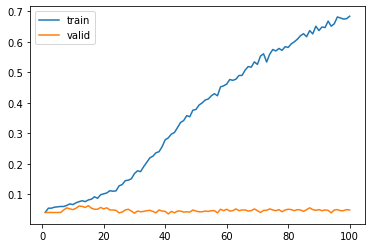

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [29]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [30]:
input_text='I know Kung'

prediction = generate_seq(model, tok, input_text, max_length=3, n_words=2)

# I know kung --> jesus 
print(f'{input_text} --> {prediction}')

I know Kung --> I know Kung kung jesus


### Conclusión 

Probé distintas con arquitecturas usando capas LSTM y BRNN, pero todos los modelos arrojaron el mismo resultado.La accurracy con el set de test sencillamente no mejora. Se terminó dejando la capa bidireccional. No pude lograr una prediccion con sentido.